# Questions to answer


In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer,VisionEncoderDecoderModel, ViTFeatureExtractor,ViTImageProcessor
import torch
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import random

In [2]:
import cv2
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

## 0. Functions

In [3]:
def check_sentence_connect(data_d):

    for s in data_d:
        story_num = s.split('_')[1]
        
        prev_target = None
        prev_gen = None
        for i in range(5):
            img_path = data_d[f'story_{story_num}_{i}']['image_path']
            target = data_d[f'story_{story_num}_{i}']['text'].split(' ')
    
            if prev_target != None:
                s1=set([i for i in prev_target if i not in excl_words])
                s2=set([i for i in target if i not in excl_words])
                intersect_words = s1.intersection(s2)
                data_d[f'story_{story_num}_{i}']['target_intersect'] = intersect_words
                data_d[f'story_{story_num}_{i}']['target_unique_len'] = len(s2)
                data_d[f'story_{story_num}_{i}']['target_pct_overlap'] = len(intersect_words)/len(s2)
            prev_target = target
            
            if os.path.exists(img_path) and ('jpg' in img_path or 'jpeg' in img_path):
                output = predict_step([img_path])
    
                if output != None:
                    data_d[f'story_{story_num}_{i}']['output'] = output[0]
                    
                    if prev_gen != None:
                        s1=set([i for i in prev_gen if i not in excl_words])
                        s2=set([i for i in output[0].split(' ') if i not in excl_words])                    
                        intersect_words = s1.intersection(s2)
                        data_d[f'story_{story_num}_{i}']['output_intersect'] = intersect_words
                        data_d[f'story_{story_num}_{i}']['output_unique_len'] = len(s2)

                        if len(s2) > 0:
                            data_d[f'story_{story_num}_{i}']['output_pct_overlap'] = len(intersect_words)/len(s2)
                    
                    prev_gen = output[0].split(' ')
    

In [4]:
def get_connected_stats(data_d):

    avg = []
    target_words_denom = 0 
    target_words_num = 0
    
    model_words_denom = 0 
    model_words_num = 0

    c=0
    for i in data_d:
        if 'target_pct_overlap' in data_d[i] and 'output_intersect' in data_d[i]:
            avg.append(data_d[i]['target_pct_overlap'])
            target_words_num += len(data_d[i]['target_intersect'])
            target_words_denom += data_d[i]['target_unique_len']
        
            model_words_num += len(data_d[i]['output_intersect'])
            model_words_denom += data_d[i]['output_unique_len']
        else:
            c+=1

    print("Average target overlap %: ", sum(avg)/len(avg))
    print("Overall taregt overlap: ", target_words_num/target_words_denom, target_words_num, target_words_denom)
    print("Overall prediction overlap: ", model_words_num/model_words_denom, model_words_num, model_words_denom)
    print(f"skipped {c}")
    

In [5]:
max_length = 100
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(loadedmodel, image_paths):
    images = []
    for image_path in image_paths:

        try:
            i_image = Image.open(image_path)
        except:
            return None
            
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
    
        images.append(i_image)
    
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    output_ids = loadedmodel.generate(pixel_values, **gen_kwargs)

    # print(output_ids)
    
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    
    return preds

## 0. Load feature extractor

In [6]:
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Load VIST test data

In [7]:
ann = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/annotations")
labels = open("/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/annotations/TestStoriesFin.json")
labels = json.load(labels)

In [8]:
test = {}
for s in labels:
    for idx, im in enumerate(labels[s]['img_ids']):
        image_path = f"/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/{im}.jpeg"
        key = f"story_{s}"
        if key not in test:
            test[key] = {}
        test[key][idx] = {}
        test[key][idx]['image_path'] = image_path
        test[key][idx]['text'] = labels[s]['text'][idx]


In [9]:
from nltk.corpus import stopwords

excl_words = stopwords.words('english') + [".",",","-","!","?"]

In [10]:
excl_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### Load AI generated image datasets (book summ)

In [11]:
c_stories = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/labels")

In [12]:
len(c_stories)

70

In [13]:
c_test = {}

In [14]:
org_im_path = "/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/images"
org_lab_path = "/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/labels"
for c in c_stories:
    c_test[c] = {}
    c_test[c]["image_paths"] = []
    c_test[c]["text"] = []
    imgs = sorted(os.listdir(f"{org_im_path}/{c}"))
    imgs = [i for i in imgs if '.jpg' in i]
    for im in imgs:
        lab = im.replace('.jpg','.txt')
        sen = open(f"{org_lab_path}/{c}/{lab}").read()
        c_test[c]["text"].append(sen)
        c_test[c]["image_paths"].append(org_im_path + f'/{c}/' + im)

In [15]:
book_summ = {}
for s in c_test:
    for idx, im in enumerate(c_test[s]['image_paths']):
        book_summ[f'story_{s}_{idx}'] = {}
        book_summ[f'story_{s}_{idx}']['image_path'] = c_test[s]['image_paths'][idx]
        book_summ[f'story_{s}_{idx}']['text'] = c_test[s]['text'][idx]

### Load model

In [16]:
model_loaded = VisionEncoderDecoderModel.from_pretrained('finalModels/model_epoch1_img_5000_VIST/')

In [17]:
model_loaded.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# 2. Fine-tune on the VIST dataset

    Actually, I think we do not need to fine-tune the feature extractor.
    Just fine-tune the decoder based on the features produced by the extractor

In [18]:
class CustomImageDataset(Dataset):
    
    def __init__(self, stories_annotations, img_dir=None, transform=None, target_transform=None):
        self.stories = stories_annotations
        self.stories_keys = list(stories_annotations.keys())
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        """Returns the number of samples in our dataset
        """
        return len(list(self.stories.keys()))

    def __getitem__(self, idx):

        if idx >= self.__len__():
            return
        story_num = self.stories_keys[idx]
        # print("Story num is ", story_num)
        
        # get label
        label = self.stories[story_num]['text']
        
        # get images
        inputs = {}
        image_path = self.stories[story_num]['image_path']
        
        try:
            image = read_image(image_path)
            image = feature_extractor(images=image, return_tensors="pt").pixel_values
            inputs['pixel_values'] = image.squeeze()
            
            # set label
            label = self.stories[story_num]['text']
            tok_out = tokenizer(label, padding="max_length")
            lab = tok_out.input_ids # omitted max_target_lengths
            lab = torch.tensor(lab).squeeze()
            
            att = tok_out.attention_mask
            att = torch.tensor(att).squeeze()

            if lab.shape[-1] != 1024:
                return self.__getitem__(idx+1)

            inputs['labels'] = lab#.unsqueeze(dim=0)
            inputs['attention_mask'] = att
        except:
            return self.__getitem__(idx+1)
        
        return inputs

In [19]:
custom_train_data = CustomImageDataset(book_summ)
train_dataloader = DataLoader(custom_train_data, batch_size=1, shuffle=True)

In [20]:
out = next(iter(train_dataloader))

In [21]:
out['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [22]:
out['labels'].shape

torch.Size([1, 1024])

In [23]:
out['attention_mask'].shape

torch.Size([1, 1024])

In [24]:
max_len = 0
for i in book_summ:
    if len(book_summ[i]['text'].split()) > max_len:
        max_len = len(book_summ[i]['text'].split())
print(max_len)

979


### Model initial performance on this data

In [25]:
c_test['10']

{'image_paths': ['/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/images/10/0.jpg',
  '/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/images/10/1.jpg',
  '/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/images/10/2.jpg',
  '/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/images/10/3.jpg',
  '/home/jay.je/IMspiredStoryTelling/datasets/bookSumm/images/10/4.jpg'],
 'text': ["the king and queen of hearts were seated on their throne when they arrived, with a great crowd assembled about them--all sorts of little birds and beasts, as well as the whole pack of cards: the knave was standing before them, in chains, with a soldier on each side to guard him; and near the king was the white rabbit, with a trumpet in one hand, and a scroll of parchment in the other. in the very middle of the court was a table, with a large dish of tarts upon it: they looked so good, that it made alice quite hungry to look at them--'i wish they'd get the trial done,' she thought, 'and hand round the 

In [30]:
res = predict_step(model_loaded, c_test['10']['image_paths'])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Original text:  the king and queen of hearts were seated on their throne when they arrived, with a great crowd assembled about them--all sorts of little birds and beasts, as well as the whole pack of cards: the knave was standing before them, in chains, with a soldier on each side to guard him; and near the king was the white rabbit, with a trumpet in one hand, and a scroll of parchment in the other. in the very middle of the court was a table, with a large dish of tarts upon it: they looked so good, that it made alice quite hungry to look at them--'i wish they'd get the trial done,' she thought, 'and hand round the refreshments!' but there seemed to be no chance of this, so she began looking at everything about her, to pass away the time.


Model result:  i had to go to the restaurant to see what was in the cake.


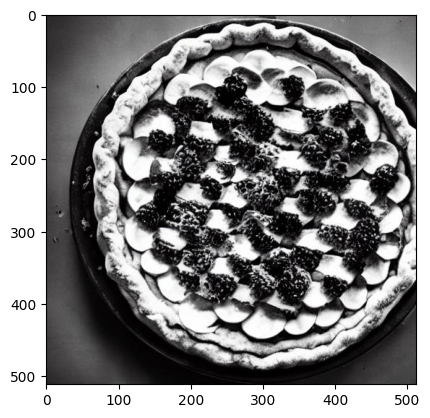

Original text:  alice had never been in a court of justice before, but she had read about them in books, and she was quite pleased to find that she knew the name of nearly everything there. 'that's the judge,' she said to herself, 'because of his great wig.'


Model result:  [male] [male] [male] [male] [male] [male] [male]


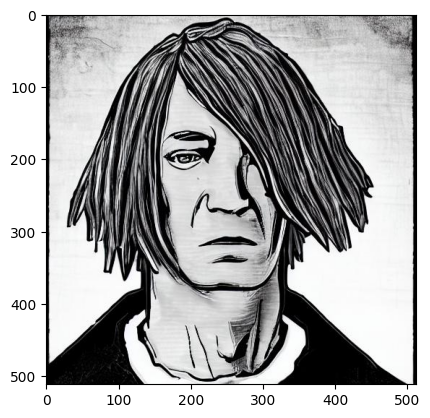

Original text:  the judge, by the way, was the king; and as he wore his crown over the wig, (look at the frontispiece if you want to see how he did it,) he did not look at all comfortable, and it was certainly not becoming.


Model result:  it was a great time to see the fireworks.


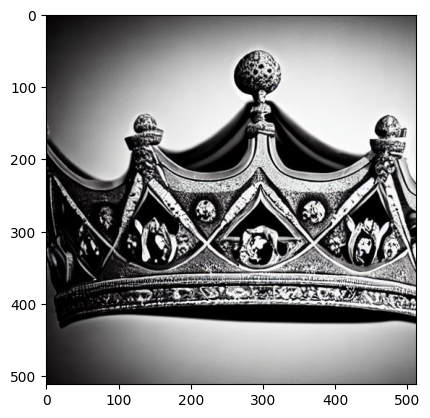

Original text:  'and that's the jury-box,' thought alice, 'and those twelve creatures,' (she was obliged to say 'creatures,' you see, because some of them were animals, and some were birds,) 'i suppose they are the jurors.' she said this last word two or three times over to herself, being rather proud of it: for she thought, and rightly too, that very few little girls of her age knew the meaning of it at all. however, 'jury-men' would have done just as well.


Model result:  i had to do a lot of work to get my picture taken.


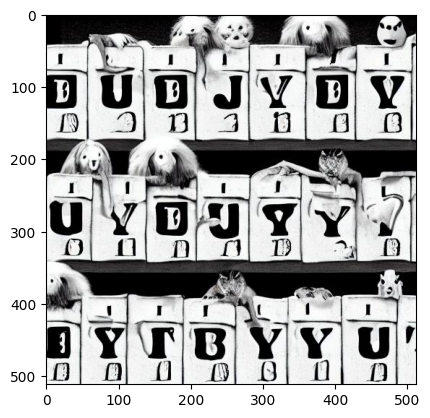

Original text:  the twelve jurors were all writing very busily on slates. 'what are they doing?' alice whispered to the gryphon. 'they can't have anything to put down yet, before the trial's begun.'


Model result:  we had a lot of fun.


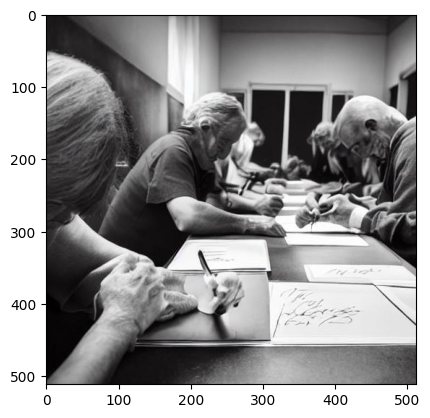

In [33]:
for idx, p in enumerate(c_test['10']['image_paths']):
    plt.imshow(Image.open(p))
    print("Original text: ", c_test['10']['text'][idx])
    print('\n')
    print("Model result: ", res[idx])
    plt.show()
    

## Now try to train the model

In [66]:
from transformers import Trainer, Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate

In [67]:
metric = evaluate.load("rouge")

In [39]:
ignore_pad_token_for_loss = True

In [43]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [44]:
def train_one_epoch(epoch_index, model, custom_data_loader, tb_writer = None):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(custom_data_loader):
        # Every data instance is an input + label pair
        inputs = data

        inputs['pixel_values'] = inputs['pixel_values'].to(device)
        inputs['labels'] = inputs['labels'].to(device)
        # inputs['attention_mask'] = inputs['attention_mask'].to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(pixel_values=inputs['pixel_values'], labels=inputs['labels'],
                        # decoder_attention_mask = inputs['attention_mask']
                       )

        # Compute the loss and its gradients
        loss = outputs.loss
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(custom_data_loader) + i + 1
            running_loss = 0.

    return last_loss

In [45]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [46]:
EPOCHS = 1
epoch_number = 0
best_vloss = 1_000_000
optimizer = torch.optim.SGD(model_loaded.parameters(), lr=0.001, momentum=0.9)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_loaded.train() # True
    avg_loss = train_one_epoch(epoch_number, model_loaded, train_dataloader) #writer)

    model_loaded.eval()
    model_loaded.save_pretrained(f'./model_epoch{epoch_number}_img_5000_VIST_with_bookSumm/')
    
    epoch_number += 1

EPOCH 1:
  batch 1 loss: 6.99593499302864e-05
  batch 101 loss: 0.05725869324430823
  batch 201 loss: 0.05458584003895521
  batch 301 loss: 0.05564366230741143


In [48]:
labels['45531']

{'sent_ids': ['227655', '227656', '227657', '227658', '227659'],
 'img_ids': ['1741625', '1741640', '1741639', '1741633', '1741630'],
 'album_id': '44277',
 'text': ['i was so excited to be heading to the crafts fair .',
  'when i arrived i saw a great booth with a variety of great crafts .',
  "i stopped at chatted at my friend [female] 's booth for a bit .",
  'there were even booths set up for all of the kids .',
  "i found some awesome crafts at the fair , i 'm really happy that i went ."]}

tensor([[50256,  1169,  1862,   582,   373,  6155,   866,   262,  4675,   351,
           465,  3625,   319,   262,  2323,   290,   465,  2832,   319,   465,
         21497,    11,   290,   465,  3625,   319,   262,  2323,    11,   290,
           465,  3625,   319,   262,  2323,    11,   290,   465,  3625,   319,
           262,  2323,    11,   290,   465,  3625,   319,   262,  2323,    11,
           290,   465,  3625,   319,   262,  2323,    11,   290,   465,  3625,
           319,   262,  2323,    11,   290,   465,  3625,   319,   262,  2323,
            11,   290,   465,  3625,   319,   262,  2323,    11,   290,   465,
          3625,   319,   262,  2323,    11,   290,   465,  3625,   319,   262,
          2323,    11,   290,   465,  3625,   319,   262,  2323,    11,   290]],
       device='cuda:0')
['the young man was walking down the street with his feet on the ground and his hands on his hips, and his feet on the ground, and his feet on the ground, and his feet on the ground, a

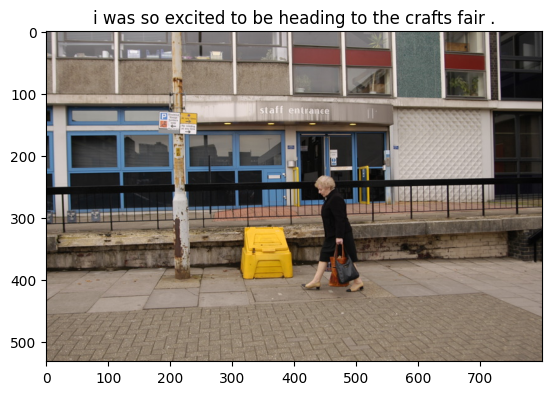

tensor([[50256,    72,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           475,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029, 50256]],
       device='cuda:0')
['i am unable to see the image above, but i am unable to see the image above, and i am unable to see the image above, and i am unable to see the image above, and i am unable to see the

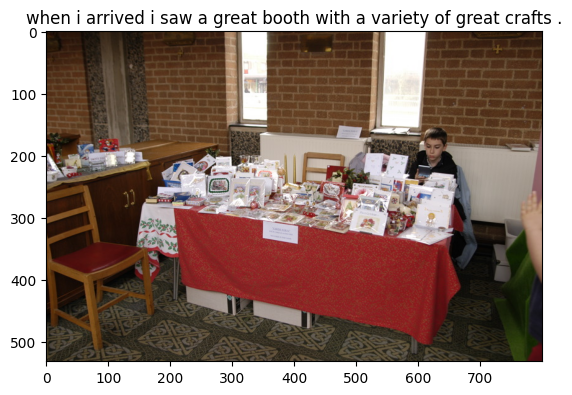

tensor([[50256,    72,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           475,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029, 50256]],
       device='cuda:0')
['i am unable to see the image above, but i am unable to see the image above, and i am unable to see the image above, and i am unable to see the image above, and i am unable to see the

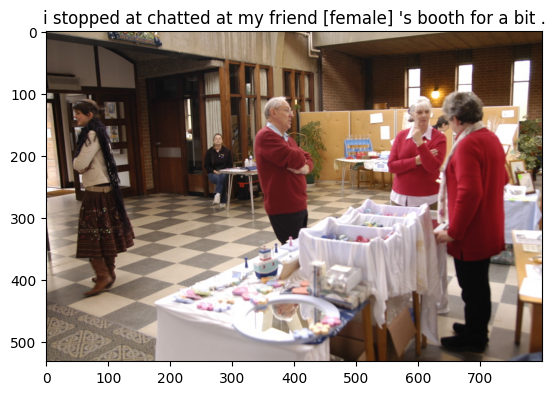

tensor([[50256,  1169,  1751,   389,  5586,   379,   262,  3084,    11,   290,
           530,   286,   606,   318,  2045,   379,   262,  3348,   319,   262,
          3084,    11,   290,   530,   286,   606,   318,  2045,   379,   262,
          3348,   319,   262,  3084,    11,   290,   530,   286,   606,   318,
          2045,   379,   262,  3348,   319,   262,  3084,    11,   290,   530,
           286,   606,   318,  2045,   379,   262,  3348,   319,   262,  3084,
            11,   290,   530,   286,   606,   318,  2045,   379,   262,  3348,
           319,   262,  3084,    11,   290,   530,   286,   606,   318,  2045,
           379,   262,  3348,   319,   262,  3084,    11,   290,   530,   286,
           606,   318,  2045,   379,   262,  3348,   319,   262,  3084,    11]],
       device='cuda:0')
['the children are sitting at the table, and one of them is looking at the paper on the table, and one of them is looking at the paper on the table, and one of them is looking at the p

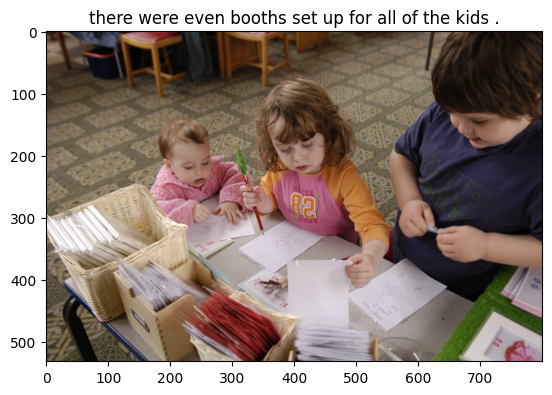

tensor([[50256,    72,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           475,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029,    11,
           290,  1312,   716,  5906,   284,   766,   262,  2939,  2029, 50256]],
       device='cuda:0')
['i am unable to see the image above, but i am unable to see the image above, and i am unable to see the image above, and i am unable to see the image above, and i am unable to see the

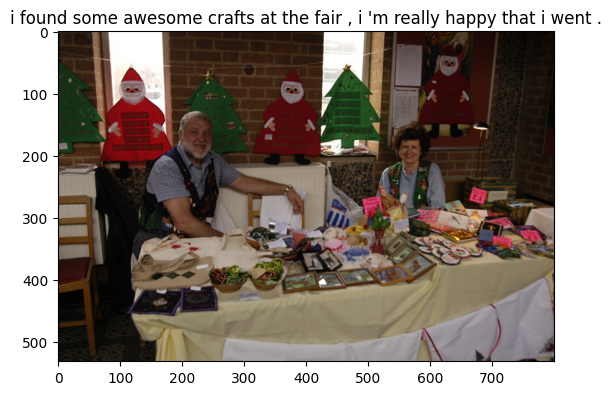

In [50]:
sample = labels['45531']
sample['image_paths'] = []
for im in sample['img_ids']:
    sample['image_paths'].append(f'/home/jay.je/IMspiredStoryTelling/datasets/VIST/test/images/{im}.jpeg')
    
for idx, s in enumerate(sample['image_paths']):
    im = Image.open(s)
    plt.imshow(im)
    plt.title(sample['text'][idx])
    print(predict_step(model_loaded, [sample['image_paths'][idx]]))
    plt.show()